In [10]:
%run ../talktools.py

## MCMC ... Continued 

### AY 128/256 (UC Berkeley, 2019)

Set up the problem and sample as in the previous notebook:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * (x + b)  # linear but note the difference from the generating model
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b = theta
    if -5.0 <= m <= 5.0 and -20 <= b <= 20:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Ndata = 10 # number of data points
m_true = 3 # true slope
b_true = -2 # true intercept
seed =   128  
rnd = np.random.RandomState(seed)

xmin, xmax = 0, 2
x = rnd.uniform(xmin, xmax, Ndata)
x.sort() 
y_data = m_true * x + b_true
y_err_min, y_err_max = 0.1, 0.7
y_err = rnd.uniform(y_err_min, y_err_max, Ndata)
y_data = rnd.normal(y_data, y_err)

ndim, nwalkers = 2, 16
initial_m, initial_b = m_true, b_true/m_true -1
pos = [(initial_m, initial_b) + 1e-4*rnd.randn(ndim) for i in range(nwalkers)]

import emcee
print(f"emcee version = {emcee.__version__}")
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))

import time
start_time = time.time()

niterations = 10000
# make sure to reset the sampler so it doesn't keep appending onto old results
sampler.reset()
sampler.run_mcmc(pos, niterations)

end_time = time.time() - start_time
print(f"This run took: {np.around(end_time,2)} seconds")
print(sampler.chain.shape) # ndim, nwalker, # of parameters
print(sampler.flatchain.shape) # ndim * nwalker, # of parameters 

emcee version = 2.2.1
This run took: 4.57 seconds
(16, 10000, 2)
(160000, 2)


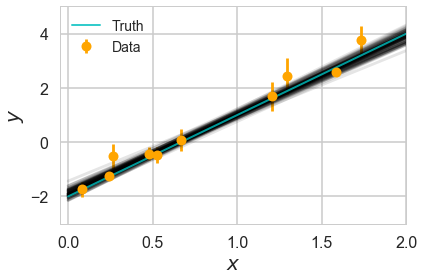

In [13]:
# let's remove the first 200 steps as "burn in"
# they are still sensitive to the initial conditions
burn_in = 1000
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
# create an array of x values
xl = np.array([0, 2])

# randomly draw 100 points from my posterior (i.e., the MCMC chain)
# and plot them as thin black lines
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*(xl + b), color="k", alpha=0.1)

# plot the true model from the very beginning
plt.plot(xl, m_true*xl+b_true, color="c", lw=2, alpha=0.8, label='Truth')

# plot the fake data with error bars
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=10, c='orange', label='Data')

#set some limits on the plot
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xlim(-0.05, 2)
plt.ylim(-3,5)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()

corner version=2.0.1


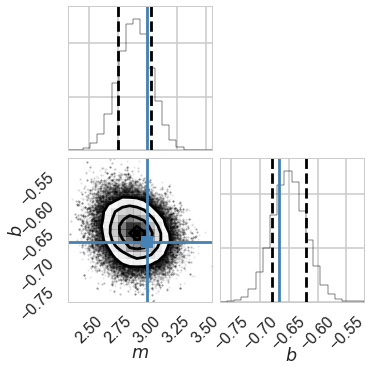

In [14]:
import corner
print(f"corner version={corner.__version__}")
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_true, b_true/m_true], quantiles=[0.16, 0.84])

Once we have samples from the posterior we can do cool things:

Suppose we have B samples $\theta_1$...$\theta_B$ from the posterior $p(\theta|$**X**):

1) **Posterior mean**: 
   
The exact equation $E[\theta|$**X**] = $\int \theta p(\theta|$**X**)$d\theta$

Using the sample $E[\theta|$**X**] $\approx \frac{1}{B} \sum_{b=1}^B \theta_b$

In [21]:
print(f"mean m from the MCMC chain = {sampler.chain[:,1000::10,0].sum()/sampler.chain[:,1000::10,0].size}")

mean m from the MCMC chain = 2.892217786011222


note the ::3 above....this is me prunning the chains to every third entry. 

2) **Marginalization**: 
   
The exact equation $p(\theta_1|$**X**) = $\int p(\theta_1,\theta_2,..\theta_p|$**X**)$d\theta_2\theta_3...\theta_p$

Using the sample $p(\theta_1|$**X**) $\sim \theta_{1,1} ... \theta_{1,B}$

*That is, record the parameter of interest $\theta_1$ from each sample.*

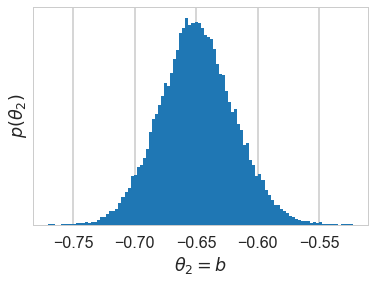

In [25]:
chain = sampler.chain[:,2000::3,1].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta_2 = b$")
plt.ylabel(r"$p(\theta_2)$");

3) **Prediction**: 
   
The exact equation $p(\tilde{X}|$**X**) = $\int p(\tilde{X}|\theta) p(\theta|$**X**)$d\theta$

Using the sample $p(\tilde{X}|$**X**) $\sim \tilde{x_1} | \theta_{1} ... \tilde{x_B} | \theta_{B}$

*That is, take each sample of $\theta$ and determine a value for $x$.*

We did that before -- making example lines given a selection of $\theta = m, b$ from the MCMC chain.

## Some general advice for checking goodness of fit:

Determining whether an MCMC has converged can be difficult, especially in high-dimensional parameter spaces: "This can be a difficult subject to discuss because it isn’t formally possible to guarantee convergence for any but the simplest models, and therefore any argument that you make will be circular and heuristic."

Here's a basic overview of how you can convince yourself and others you are on the right track.

- **First check** - start multiple chains from different starting values and see that they converge to the same place
- **More formal methods** - Raftery-Lewis, Geweke, autocorrelation, etc.
- **Goodness of fit** - Posterior Predictive Checks which simulate data from your fitted model and compare to the observed data (checks convergence AND the suitability of the chosen model)

See https://pkgw.github.io/mcmc-reporting/ and https://rlhick.people.wm.edu/stories/bayesian_5.html for some details and insights.


## Convergence Diagnostics

A number of diagnostics (both formal and informal) exist:

- Geweke score: compares mean of beginning of chain with mean of end

Geweke score = $\frac{\bar{\theta}_e - \bar{\theta}_b}{\sqrt{Var(\theta_e) + Var(\theta_b)}}$

- Gelman-Rubin: compare variance between chains to variance of single chain.  For a well converged chain the G-R stat should approach 1. Values greater than typically 1.1 indicate that the chains have not yet fully converged.

In [26]:
# see http://joergdietrich.github.io/emcee-convergence.html
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    θb = np.mean(chain, axis=1)
    θbb = np.mean(θb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((θbb - θb)**2, axis=0)
    var_θ = (n - 1) / n * W + 1 / n * B
    R̂ = np.sqrt(var_θ / W)
    return R̂

In [27]:
gelman_rubin(sampler.chain)

array([1.00180088, 1.00057149])

No handles with labels found to put in legend.


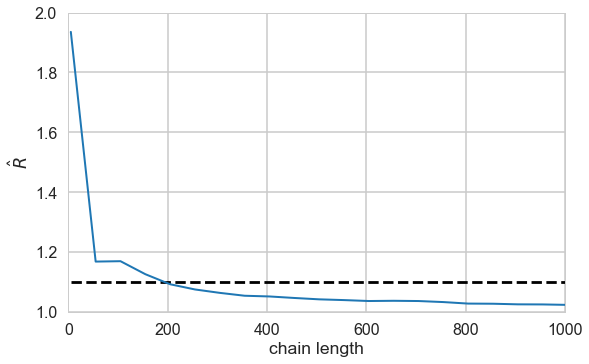

In [28]:
fig = plt.figure(figsize=(8.9, 5.5))
xmin = 5
chain = sampler.chain
chain_length = chain.shape[1]
step_sampling = np.arange(xmin, chain_length, 50)
rhat = np.array([gelman_rubin(chain[:, :steps, :])[0] for steps in step_sampling])
plt.plot(step_sampling, rhat, linewidth=2)
    
ax = plt.gca()
ax.set_xlim(0,1000)
xmax = ax.get_xlim()[1]
plt.hlines(1.1, xmin, xmax, linestyles="--")
plt.ylabel("$\hat R$")
plt.xlabel("chain length")
plt.ylim(1, 2)
legend = plt.legend(loc='best')


It is important to note that Gelman-Rubin expects chains to be independent and emcee, as designed, imposes correlations on its chains. So proceed with caution here.

### Acceptance Fraction 

From https://pkgw.github.io/mcmc-reporting/ : you should report the "jump acceptance fractions computed for each chain, or a summary of them if there are many chains and/or parameters. Acceptance fractions outside the range of 10–90% suggest that the sampler is not well-matched to your problem and are cause for concern, since your samples may not be fully exploring the posterior distribution."

In [29]:
sampler.acceptance_fraction

array([0.7131, 0.7232, 0.7055, 0.7116, 0.7142, 0.7165, 0.7032, 0.7063,
       0.7248, 0.72  , 0.7095, 0.7151, 0.7133, 0.7194, 0.7082, 0.7121])

In [ ]:
"All the world's a stage, And all the men and women merely players; They have their exits and their entrances...”

Jaques (Act II, Scene VII)
“As You Like It” - Shakespeare

### Autocorrelation

A good heuristic for assessing convergence of samplings is the integrated autocorrelation time.  The integrated autocorrelation time quantifies "the effects of sampling error on your results. The basic idea is that the samples in your chain are not independent and you must estimate the effective number of independent samples." (https://emcee.readthedocs.io/en/latest/tutorials/autocorr/#autocorr). 

See also [these lecture notes](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf).


In [30]:
import numpy as np
from emcee.autocorr import integrated_time
chain = sampler.chain
tau = np.mean([integrated_time(walker, c=2) for walker in chain], axis=0)
tau

/Users/jbloom/anaconda3/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
/Users/jbloom/anaconda3/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return acf / acf[m]
/Users/jbloom/anaconda3/lib/python3.6/site-packages/emcee/autocorr.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

array([32.33206858, 59.40166557])

You should generally chose a burn in that is at least ~5 $\times$ these values.